<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning in tensorflow part 2: fine tuning 

In [1]:
!nvidia-smi


Sun Aug 21 09:58:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-21 09:58:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-21 09:58:31 (55.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-21 09:58:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   254MB/s    in 0.6s    

2022-08-21 09:58:35 (254 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                               image_size=  IMG_SIZE,
                                                               label_mode = "categorical",
                                                               batch_size =  BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images , labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.46025818e+02 7.74221954e+01 7.04712982e+01]
   [1.51669968e+02 9.34068909e+01 8.63086777e+01]
   [1.54709183e+02 1.08565369e+02 1.04132973e+02]
   ...
   [1.40536743e+02 1.20269447e+02 9.90013428e+01]
   [1.29961945e+02 1.05208420e+02 8.81962738e+01]
   [1.20489418e+02 9.42030334e+01 7.10898132e+01]]

  [[1.57517853e+02 1.43787628e+02 1.29133926e+02]
   [1.56303894e+02 1.46519135e+02 1.33407516e+02]
   [1.51370529e+02 1.46835464e+02 1.36702484e+02]
   ...
   [1.42908157e+02 1.22305122e+02 1.02717812e+02]
   [1.29376450e+02 9.51865997e+01 7.34620285e+01]
   [1.25383781e+02 7.03207550e+01 3.41684837e+01]]

  [[1.59473846e+02 1.43294647e+02 1.32901779e+02]
   [1.59554535e+02 1.41483093e+02 1.34894775e+02]
   [1.59561234e+02 1.39178574e+02 1.36203751e+02]
   ...
   [1.43105545e+02 1.17196182e+02 9.61216507e+01]
   [1.06141640e+02 7.34185638e+01 5.21700935e+01]
   [1.19513474e+02 5.99322357e+01 2.17531719e+01]]

  ...

  [[1.50729156e+02 2.37782860e+01 3.06308861e+01]
   [1

## model 0 - Building a transfer learning model using Keras Funcional API

In [12]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape= (224,224,3), name= "input_layer")
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f" shape after GlobalAveragePooling2D: {x.shape}")

outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = "output_layers")(x)

model_0 = tf.keras.Model(inputs , outputs)

model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "transfer learning ",
                                                                         experiment_name = "10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
 shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer learning /10_percent_feature_extraction/20220821-095918
Epoch 1/5
24/24 [==============================] - 23s 259ms/step - loss: 1.9166 - accuracy: 0.4240 - val_loss: 1.3722 - val_accuracy: 0.6694
Epoch 2/5
24/24 [==============================] - 4s 153ms/step - loss: 1.1520 - accuracy: 0.7307 - val_loss: 0.9497 - val_accuracy: 0.7763
Epoch 3/5
24/24 [==============================] - 4s 153ms/step - loss: 0.8542 - accuracy: 0.7933 - val_loss: 0.7780 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 4s 152ms/step - loss: 0.6890 - accuracy: 0.8400 - val_loss: 0.6657 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 4s 153ms/step - loss: 0.5870 - accuracy: 0.8667 - val_loss: 0.6001 - val_accuracy: 0.8421


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.6150 - accuracy: 0.8364


[0.615011990070343, 0.8363999724388123]

In [14]:
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [16]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


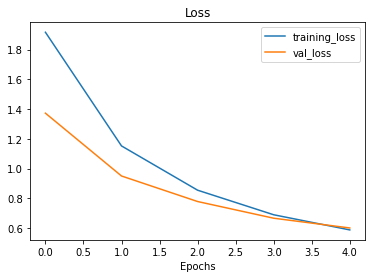

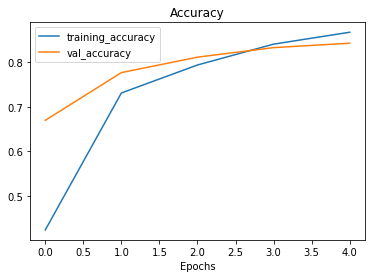

In [17]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

In [21]:
input_shape = (1,4,4,3)

tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random input shape: \n {input_tensor} \n ")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

print(f" shape of input tensor: {input_tensor.shape}")
print(f"shape of global average pooled 2D tenor: {global_average_pooled_tensor.shape}")

Random input shape: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 
 
2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

 shape of input tensor: (1, 4, 4, 3)
shape of global average pooled 2D tenor: (1, 3)


In [22]:
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>